# 2. 深層学習ベースの1次元移流方程式の近似

下記の２つの手法をベースに，深層学習フレームワークChainerを用いて1次元移流方程式を近似する

- Convolutional neural network
- Backpropagation

**参考**
- Lonena Barba [CFD Python: 12 steps to Navier-Stokes](https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/)
- 暗黙の型宣言様 [改訂版　流体計算で覚えるPython3](https://fortran.booth.pm/items/832150)
- Alex Krizhevsky et.al. [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks)
- David E. Rumelhart et. al. [Learning representations by back-propagating errors](http://www.cs.toronto.edu/~hinton/absps/naturebp.pdf)
- Preferred Networks, Inc [Chainer](https://chainer.org/)

## モジュールをインポート

In [1]:
import random

import numpy as np
import cupy as cp

import pylab as plt

from IPython import display

import chainer
import chainer.functions as F
import chainer.links as L

## 定数を定義

In [2]:
#空間
Lx = 1. #計算領域
Nx = 101 #計算点数
dx = Lx / (Nx-1) #離散点間の距離

#時間
Lt = 1. #計算時間
Nt = 1000 #計算回数
dt = Lt / Nt #計算時間の間隔

#移流速度
c = 1.

## 初期条件

In [3]:
def initial(Lx,Nx):
    """
    空間の初期化
    """
    x = np.linspace(0, Lx, Nx, dtype=np.float32)
    u = (1. - np.cos(2 * np.pi * x / Lx) / 2.) ** 10
    return x,u

## 空間微分

In [4]:
def calc_diff(u, dx):
    '''
    中心差分法（2次方法）
    '''
    dudx = np.zeros_like(u)
    dudx[1:-1] = u[2:] - u[:-2]
    dudx[0] = u[1] - u[-1]
    dudx[-1] = u[0] - u[-2]
    dudx /= 2 * dx
    return dudx

## 時間積分

In [5]:
def forward_eiler(u, dx, dt, c=1.):
    '''
    オイラー法（1次方法）
    '''
    dudx = calc_diff(u, dx)
    u_next = u - c * dudx * dt
    return u_next

## データセット作成
1. 正解値のデータ
2. ノイズ付加をしたデータ

In [6]:
# 1.正解データ
def data_exact(Lx,Nx,Nt):
    _, u = initial(Lx,Nx)
    us_exact = [u]
    
    for t in range(Nt):
        u = forward_eiler(u, dx, dt, c)
        us_exact.append(u)
        
    return us_exact 

In [7]:
# 2.ノイズ付加したデータ
def data_noise(noise,Lx,Nx,Nt,us,us_noise):
    _, u = initial(Lx,Nx)
    
    us_exact.append(u)
    us_noise.append(u)
    
    for t in range(Nt):
        u = forward_eiler(u, dx, dt, c)
        u_noise = u * (1. + noise * (0.5 - np.random.rand(Nx))) 
        us_exact.append(u)
        us_noise.append(u_noise)
    return us_exact, us_noise

# Convolutional neural network
## モデルの定義

In [8]:
class Model(chainer.Chain):

    def __init__(self):
        super(Model, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution1D(1, 32, ksize=3, stride=1, pad=1)
            self.conv2 = L.Convolution1D(32, 32, ksize=3, stride=1, pad=1)
            self.conv3 = L.Convolution1D(32, 1, ksize=3, stride=1, pad=1)
    
    def __call__(self, u):
        h = F.elu(self.conv1(u))
        h = F.elu(self.conv2(h))
        h = F.elu(self.conv2(h))
        u_next_pred = self.conv3(h)
        return u_next_pred


## 正解値データで流れ場を学習・予測

In [9]:
#データセット作成
us_exact = data_exact(Lx,Nx,Nt)
us_exact = np.array(us_exact,dtype=np.float32)

In [10]:
#モデル作成
model = Model()
lr=1e-5
optimizer = chainer.optimizers.MomentumSGD(lr=lr)
optimizer.setup(model)

In [11]:
#学習
epoch = 1000
b = 8
p = 200
for e in range(epoch):
    perm = np.random.permutation(p)
    for i in range(0, p, b):
        
        #教師データに次の流れ場 u の正解値データ
        u_next_exact = us_exact[perm[i:i+b]+1].reshape(-1, 1, Nx)

        #インプットに正解値データ u
        #次の流れ場 u_next を予測
        u = us_exact[perm[i:i+b]].reshape(-1, 1, Nx)
        u_next_pred = model(u)

        model.cleargrads()
        loss = F.mean_squared_error(u_next_pred, u_next_exact)
        loss.backward()
        optimizer.update()

        print(loss.data)

861.84656
290.30972
5.6742997
118.813995
244.59642
124.861786
10.199154
24.544802
86.76063
114.48412
94.38146
46.27892
6.7570353
6.161036
39.47967
58.374573
36.66062
7.311718
1.3132969
14.111915
27.55943
30.59538
21.922363
8.765145
0.6911109
3.2176433
11.831273
15.803435
10.913831
3.3365684
0.29168993
2.6389027
6.561047
8.31326
6.7459483
3.3023481
0.63360965
0.58716
2.5797524
4.24716
3.8660755
1.9882723
0.46585506
0.37266076
1.3090872
2.1883028
2.240539
1.4759933
0.57395744
0.20338407
0.51423657
1.0667723
1.2733716
0.9610469
0.45516145
0.18337911
0.2837688
0.56333274
0.7247848
0.6334684
0.38750246
0.19127393
0.17102686
0.29743624
0.4180784
0.41415834
0.29673284
0.17486021
0.13716601
0.19069003
0.25912577
0.27362195
0.22673346
0.16068238
0.12167654
0.13450366
0.17078978
0.18922693
0.1735053
0.13655362
0.10991624
0.11022726
0.12601732
0.13924381
0.13434748
0.11531956
0.09908917
0.09254777
0.099766694
0.1073223
0.10604997
0.09778059
0.086384326
0.08087553
0.081656136
0.08497488
0.08633549

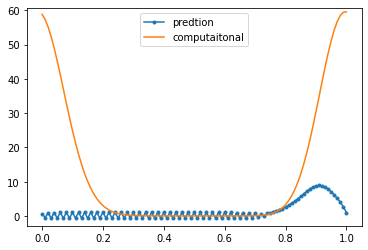

In [12]:
#予測結果比較
x, u = initial(Lx,Nx)

u_comp = u
u_pred = u

fig, ax = plt.subplots()
pred, = ax.plot(x, u_pred, marker='.',label='predtion')
comp, = ax.plot(x, u_comp,label='computaitonal')
ax.legend(loc='best')


display.display(fig)
display.clear_output(wait=True)

for t in range(500):
    u_pred = model(u_pred.reshape(1, 1, Nx))[0, 0].data
    u_comp = us_exact[t+1]

    pred.set_ydata(u_pred)
    comp.set_ydata(u_comp)

    display.display(fig)
    display.clear_output(wait=True)

## ノイズを付加したデータで流れを学習・予測

In [13]:
#データセット作成
#ノイズを付加したデータを5種類作成
noise = 1e-4
us_exact = []
us_noise = []
for i in range(5):
    us_exact, us_noise = data_noise(noise,Lx,Nx,Nt,us_exact,us_noise)

us_exact = np.array(us_exact,dtype=np.float32)
us_noise = np.array(us_noise,dtype=np.float32)

In [14]:
#モデル作成
model_noise = Model()
lr=1e-5
optimizer = chainer.optimizers.MomentumSGD(lr=lr)
optimizer.setup(model_noise)

In [15]:
#学習
epoch = 1000
b = 8
p = 200
for e in range(epoch):
    perm = np.random.permutation(p)
    for i in range(0, p, b):
        
        #教師データに次の流れ場 u_next の正解値データ
        u_next_exact = us_exact[perm[i:i+b]+1].reshape(-1, 1, Nx)

        #インプットにノイズ付加のデータ u_noise
        #次の流れ場 u_next を予測
        u = us_noise[perm[i:i+b]].reshape(-1, 1, Nx)
        u_next_pred = model_noise(u)

        model_noise.cleargrads()
        loss = F.mean_squared_error(u_next_pred, u_next_exact)
        loss.backward()
        optimizer.update()

        print(loss.data)

444.7448
177.12694
8.41146
63.92311
179.33173
91.88976
3.5058322
23.215109
69.649925
91.39215
79.678986
44.771973
10.045282
2.1344924
27.001917
46.85392
31.441214
6.4819207
1.3972687
12.265371
23.322004
25.048962
17.241783
6.1456504
0.61091584
4.7386694
12.325605
13.208126
6.7944283
1.2501937
1.408736
5.0288434
7.7203803
7.087873
3.9389138
1.0915433
0.8436975
2.838552
4.413363
3.7073262
1.6996082
0.5417938
0.9890962
2.1056685
2.6140318
2.0728056
1.0602064
0.4766223
0.73161083
1.3621893
1.5857124
1.1778406
0.6120034
0.42609847
0.6605908
0.9645742
0.99248767
0.7513865
0.46008036
0.38805714
0.5321432
0.68701804
0.66922086
0.50825834
0.3675745
0.36092728
0.45037514
0.5189153
0.4888857
0.39116204
0.32107964
0.32862034
0.3786159
0.40278724
0.37170073
0.31661552
0.28667492
0.2986878
0.32213816
0.32712805
0.30140504
0.2721593
0.2576327
0.26479918
0.27477565
0.2721164
0.25456977
0.23748001
0.2309126
0.23551568
0.23710732
0.23256211
0.2196897
0.21097304
0.20673214
0.20633434
0.20573552
0.1997722

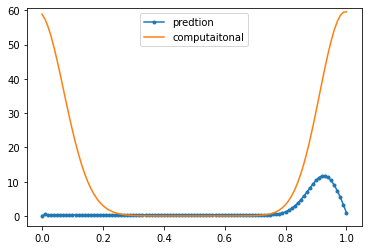

In [16]:
#予測結果比較
x, u = initial(Lx,Nx)

u_comp = u
u_pred = u

fig, ax = plt.subplots()
pred, = ax.plot(x, u_pred, marker='.',label='predtion')
comp, = ax.plot(x, u_comp,label='computaitonal')
ax.legend(loc='best')


display.display(fig)
display.clear_output(wait=True)

for t in range(500):
    u_pred = model_noise(u_pred.reshape(1, 1, Nx))[0, 0].data
    u_comp = us_exact[t+1]

    pred.set_ydata(u_pred)
    comp.set_ydata(u_comp)

    display.display(fig)
    display.clear_output(wait=True)

# Backpropagation

## モデルの定義
- データセット作成に使用したパラメタを推定
- 推定するパラメタ： c, dx, dt

In [17]:
class Model_b(chainer.Chain):

    def __init__(self):
        super(Model_b, self).__init__()
        with self.init_scope():
            # 求めるパラメタを適当に 1 で初期化 
            self.c = chainer.Parameter(np.array(1., dtype=np.float32))
            self.dx = chainer.Parameter(np.array(1., dtype=np.float32))
            self.dt = chainer.Parameter(np.array(1., dtype=np.float32))

    def __call__(self, u):
        # CFDと全く同じ方法で次点の u を推定する．
        # ただし、c, dx, dt は自分の持っているものを使う．
        h = F.concat([u[:, :, -1:], u, u[:, :, :1]], axis=2)
        h = h[:, :, 2:] - h[:, :, :-2]
        dudx = h / (2 * self.dx)

        u_next = u - self.c * dudx * self.dt
        return u_next

In [18]:
model_b = Model_b()

optimizer = chainer.optimizers.Adam(alpha=3e-4)
optimizer.setup(model_b)

In [19]:
for e in range(100):
    perm = np.random.permutation(1000)
    sum_loss = 0.
    for i in range(0, 1000, 32):
        
        #教師データに次の流れ場 u の正解値データ
        u_next_true = us_exact[perm[i:i+8]+1].reshape(-1, 1, Nx)
        
        #インプットに正解値データ u
        #次の流れ場 u_next を予測
        u = us_exact[perm[i:i+8]].reshape(-1, 1, Nx)
        u_next_pred = model_b(u)

        model_b.cleargrads()
        loss = F.mean_absolute_error(u_next_pred, u_next_true)
        loss.backward()
        optimizer.update()

        sum_loss += loss.data * 32

    print(sum_loss / 1000)

1.0672941131591798
1.0355580444335937
1.0017601013183595
0.9747697982788086
0.9403950366973877
0.9102368831634522
0.8840875835418701
0.8579443225860596
0.8315067291259766
0.8045504741668701
0.7812587051391602
0.7567745113372802
0.733883825302124
0.7109876003265381
0.688773530960083
0.6674472942352295
0.6488240413665771
0.6273537673950196
0.6093063220977784
0.5899527282714844
0.5725445671081543
0.5539468746185303
0.5364592113494873
0.5206807584762573
0.5041916017532349
0.48778597259521483
0.47345968246459963
0.4570897436141968
0.4427811574935913
0.4293551378250122
0.41443752574920656
0.40151492404937744
0.38777555561065674
0.3755829792022705
0.36322947406768796
0.3500408306121826
0.33813747787475584
0.3270301275253296
0.31504206562042236
0.3043278856277466
0.2936465072631836
0.2829887943267822
0.2726196041107178
0.2624569435119629
0.2526213188171387
0.24367366409301758
0.23353556203842163
0.22444441604614257
0.21490061187744142
0.20653077507019044
0.19778771448135377
0.18957467794418334

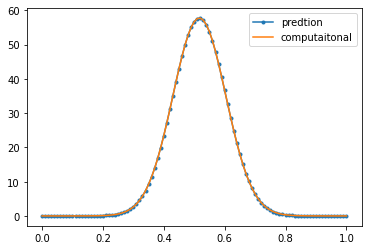

In [ ]:
#予測結果比較
x, u = initial(Lx,Nx)

u_comp = u
u_pred = u

fig, ax = plt.subplots()
pred, = ax.plot(x, u_pred, marker='.',label='predtion')
comp, = ax.plot(x, u_comp,label='computaitonal')
ax.legend(loc='best')


display.display(fig)
display.clear_output(wait=True)

for t in range(500):
    u_pred = model_b(u_pred.reshape(1, 1, Nx))[0, 0].data
    u_comp = us_exact[t+1]

    pred.set_ydata(u_pred)
    comp.set_ydata(u_comp)

    display.display(fig)
    display.clear_output(wait=True)